# Ramsey model in continuous time

Here I solve computationally Ramsey's model in continuous time. My main objective is to show how the phase diagram and saddle path change according to the parameters. This isn't an extensive treatment of the model, but rather a demonstration of how to solve the central planner's problem in continuous time. I will give a brief explanation of the optimization problem analistically, but you should refer to a textbook or lecture note for a more complete treatment.


In the model, households derive utility from consuming an homogenous good $c$. We assume that households supply, inelastically, one unit of labor. Since we have no kind of frictions, the decentralized equilibrium is the same as the centralized one. Hence, I will directly solve the central planner's problem. The central planner wants to maximize the discounted sum of the utility of the households, subject to the budget constraint. The budget constraint is the law of motion of the capital stock, which is the savings of the households $Af(k_t) - c_t$ minus the depreciation of the capital stock $\delta k_t$.

Thus, generically, the central planner's problem is:


$$
\begin{align*}
\max \quad & \int_0^\infty e^{-\rho t} u(c_t) dt \\
\text{s.t.} \quad & \dot k_t = Af(k_t) - c_t - \delta k_t \\
\end{align*}
$$

We can write the Current Value Hamiltonian as:
$$
\mathcal{H}^c = u(c_t) + \mu_t (Af(k_t) - c_t - \delta k_t)
$$

Taking the derivatives and deriving the first-order conditions with regards to the control variable ($c_t$) and the state variable ($k_t$) we get:

$$
\begin{align*}
\frac{\partial \mathcal{H}^c}{\partial c_t} & = u'(c_t) - \mu_t  =  0 \\
\frac{\partial \mathcal{H}^c}{\partial k_t} & = \mu_t A f'(k_t) - \delta = \rho \mu_t - \dot \mu_t
\end{align*}
$$

Assuming that the utility function $u(c_t)$ has a constant relative risk aversion $\theta$ (like, $ u(c_t) = \frac{c_t^{1-\theta}}{1-\theta} $), and manipulating the expressions, we arrive at the following equilibrium conditions:


$$
\begin{align}
\frac{\dot c_t}{c_t} & = \frac{Af'(k_t) -\delta -\rho }{\theta} \\
\dot k_t & = Af(k_t) - \delta k_t -c_t
\end{align}
$$ 


If we consider $f(k) = k^\alpha$, we get:
$$
\begin{align}
\frac{\dot c_t}{c_t} & = \frac{A\alpha k_t^{\alpha -1 } -\delta -\rho }{\theta} \\
\dot k_t & = Ak_t^\alpha - \delta k_t -c_t
\end{align}
$$ 

These are the two key equations that we will use to i) solve for the steady state, ii) plot the phase diagram, and iii) plot the saddle path. The code below solves the model numerically. 

I implement the solution using a class, which is a convenient way to store the parameters of the model and the solution. If you're not familiar with classes, you can see a simpler version of this code in this repository implementing the solutions using functions.

In [5]:
# Importing necessary libraries:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# Defining default values for graph plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 15})

In [6]:
# Now, we want to implement these methods into a class, in order to make it easier to use:
class Ramsey:
    def __init__(self, A=1, alpha=0.3, delta=0.05, rho=0.02, theta=0.5, fine=60, far=1.5):
        self.A, self.alpha, self.delta, self.rho, self.theta = A, alpha, delta, rho, theta
        self.fine, self.far = fine, far
        
        # Finding the steady state:
        self.k_ss = (A*alpha/(delta+rho))**(1/(1-alpha))
        self.c_ss = A*self.k_ss**alpha - delta*self.k_ss
        
        # Defining the grid for consumption and capital:
        self.k_grid = np.linspace(0, self.k_ss*far, fine)
        self.c_grid = np.linspace(0, self.c_ss*far, fine)
        
        # Setting the nullcine equations:
        self.c_null = (A*alpha/(delta + rho))**(1/(1-alpha))
        self.k_null = A*self.k_grid**alpha - delta*self.k_grid
        
        # Setting the grids to be used in the phase diagram:
        self.M1, self.M2 = np.meshgrid(self.c_grid, self.k_grid)
        
        # Evaluating the differential equations in the grid:
        # Ps: This uses a function that I defined below.
        self.dc_grid, self.dk_grid = self.dc_dk(self.M1, self.M2)
        
       # Some arbitrary initial conditions to plot the explosive paths:
        self.arbitrary_init = np.array([(self.k_ss*0.1,self.c_ss*0.1),
                                (self.k_ss*0.2,self.c_ss*0.4),
                                (self.k_ss*1.3,self.c_ss*1.3),
                                (self.k_ss*1.4,self.c_ss*1.2)])
        
        
    # Defining a function that plots the nullcine equations:
    def simple_graph(self):
        plt.plot([self.c_null]*self.fine, self.c_grid, color = 'green', label='$\\dot c = 0$', linewidth=2)
        plt.plot(self.k_grid, self.k_null, color = 'red', label='$\\dot k = 0$', linewidth=2)
        plt.xlabel('Capital ($k$)')
        plt.ylabel('Consumption ($c$)')
        plt.ylim(0, self.c_grid[-1])
        plt.xlim(0, self.k_grid[-1])
        plt.legend()
        plt.grid()
        
    # Defining the differential equations:
    def dc_dk(self, c,k):
        # Ps: we have some zeros in the grid and this will cause Python to report a warning. 
        # To avoid that we will use the np.errstate function:
        with np.errstate(divide='ignore', invalid='ignore'):
            dc = c*(self.A*self.alpha*k**(self.alpha-1) - self.delta - self.rho)/self.theta
            dk = self.A*k**self.alpha - self.delta*k - c
        return dc, dk
    
    # Function to plot the phase diagram using the quiver function:
    def graph_quiver(self, n=3):
        # I load the simple graph function:
        self.simple_graph()
        # Because the grid is usually too dense, we only plot the n-th arrow:
        plt.quiver(self.M2[::n], self.M1[::n], self.dk_grid[::n], self.dc_grid[::n], 
                   angles = 'xy', scale_units = 'xy', scale = 2.5)
        
    # Function to plot the phase diagram using the streamplot function:
    def graph_streamplot(self):
        # I load the simple graph function:
        self.simple_graph()
        # Plotting the streamplot:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), density=1)
    
    # Function to plot the phase diagram with a saddle path:
    def graph_saddle_path(self):        
        # Plotting the streamplot:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), start_points=[ 
                                                                                                (self.k_ss,self.c_ss), 
                                                                                                (self.k_ss+1e-2,self.c_ss+1e-2)], integration_direction='backward',
                                                                                        broken_streamlines=False, color="orange", arrowsize=2, linewidth=2)
        # Plloting the old streamplot:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), density=0.5, arrowsize=1, linewidth=0.5)
        plt.plot([], [], '-', color="orange", label='Saddle Path')
         # I load the simple graph function:
        self.simple_graph()
    
    # Function to plot the phase diagram with some explosive paths:
    def graph_explosive_paths(self, init_cond):
        # Adding explosive paths:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), start_points=init_cond,
                       color='purple', integration_direction='forward', broken_streamlines=False, linewidth=2)
        # Also plotting the points of the initial conditions:
        plt.scatter(init_cond[:,0], init_cond[:,1], color='purple')
        # Plotting the saddle path:
        plt.streamplot(self.k_grid, self.c_grid, np.transpose(self.dk_grid), np.transpose(self.dc_grid), 
                       start_points=[ (self.k_ss,self.c_ss),(self.k_ss+1e-3,self.c_ss+1e-3)], 
                       integration_direction='backward',broken_streamlines=False, color="orange", arrowsize=2, linewidth=2)
        plt.plot([], [], '-', color="orange", label='Saddle Path')
        plt.plot([], [], '-', color="purple", label='Explosive Paths')
        self.simple_graph()
    
    
        



Let me give a brief explanation of how to use the class. First, you must choose the exogenous parameters of the model. The parameters are: $\alpha$, $\delta$, $\rho$, $\theta$, and $A$. For example, let's say that we want to solve the model with $A=1$, $\alpha = 0.3$, $\delta = 0.05$, $\rho = 0.02$, and $\theta = 0.5$. We can create an instance of the class (saved as `R1`) with the following code:

In [9]:
R1 = Ramsey(A=1, alpha = 0.3, delta = 0.05, rho=0.02, theta=0.5)

When we ran this instance, the class automatically calculated the steady state of the model, and stored it in the object `R1.k_ss` and `R1.c_ss`. We can print the steady state values with the following code:


In [14]:
# Printing the steady state values:
print('Steady state values:')
print('Capital =', R1.k_ss)
print('Consumption =', R1.c_ss)


Steady state values:
Capital = 7.996322598960654
Consumption = 1.4659924764761196


We can plot the graph of the two equilibrium conditions by calling the method `simple_graph` of the class:

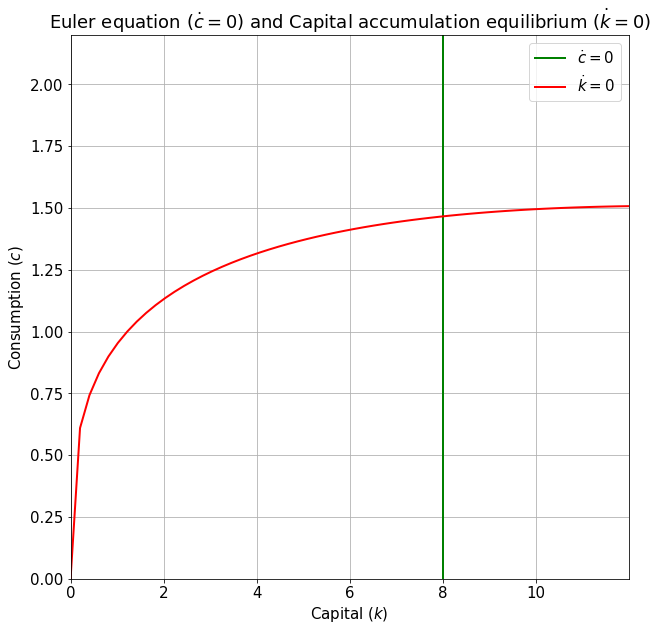

In [15]:
# Plotting the nullclines:
plt.title('Euler equation ($\dot c = 0$) and Capital accumulation equilibrium ($\dot k = 0$)')
R1.simple_graph()
plt.show()

We can plot the phase diagram by calling the method `graph_streamplot` of the class:
    

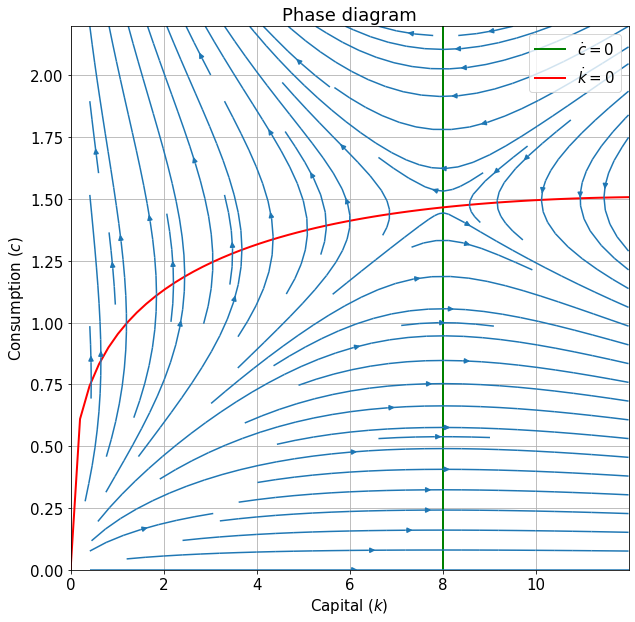

In [16]:
# Plot with streamline
plt.title('Phase diagram')
R1.graph_streamplot()
plt.show()

The plot above give as a sense of direction of the dynamics of the model, but it doesn't give us a sense of the speed of the dynamics. To better grasp this, we can plot the same phase diagram, but with a quiver graph. In the quiver graph, the arrows are proportional to the speed of the dynamics. We can plot the quiver graph by calling the method `graph_quiver` of the class:

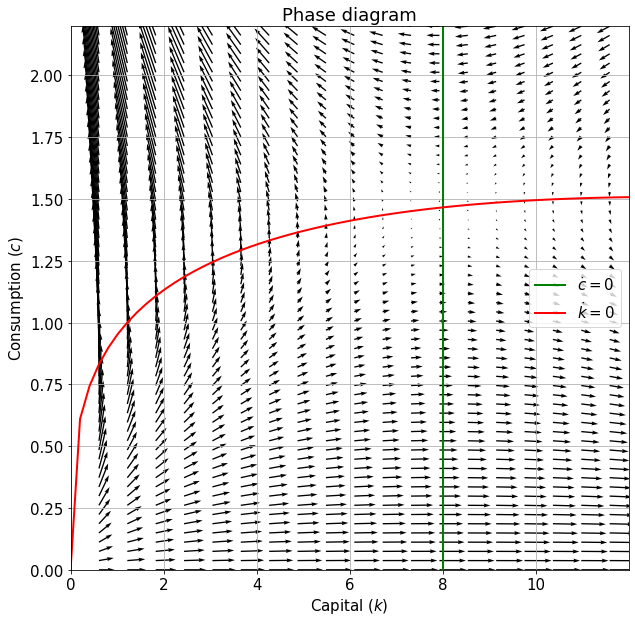

In [17]:
# Plot the direction field
plt.title('Phase diagram')
R1.graph_quiver()
plt.show()

Finally, we can plot the saddle path by calling the method `graph_saddle_path` of the class:

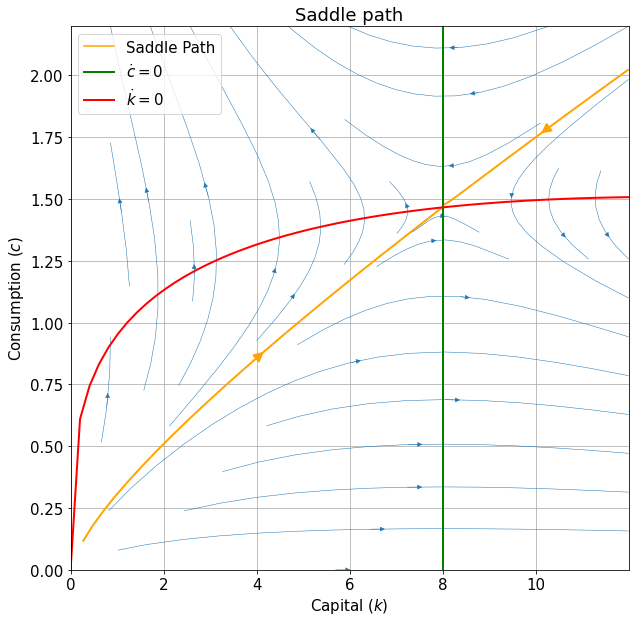

In [18]:
# Plot with saddle path
plt.title('Saddle path')
R1.graph_saddle_path()
plt.show()

We can also plot what is the trajectory for some arbitrary initial conditions. We can do this using the method `graph_explosive_path` of the class:

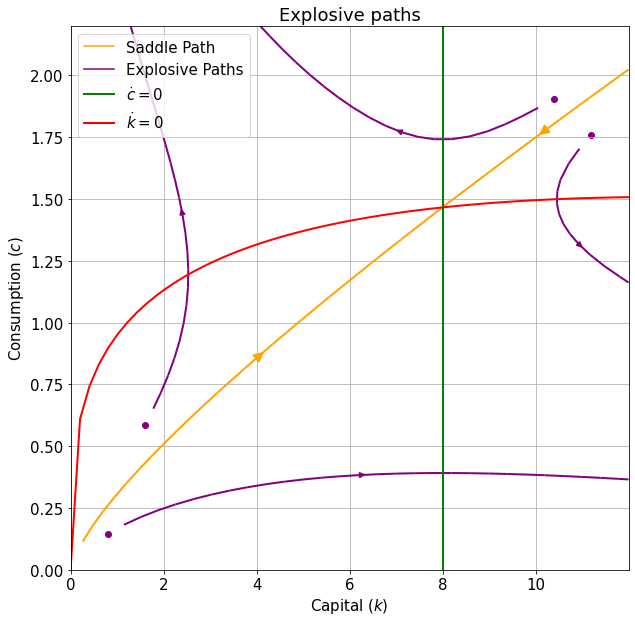

In [19]:
# Plot some explosive paths:
plt.title('Explosive paths')
R1.graph_explosive_paths(R1.arbitrary_init)
plt.show()